
# AAI612: Deep Learning & its Applications

*Notebook 8.1: Text Preprocessing Using *Scikit-learn*

<a href="https://colab.research.google.com/github/jgeitani/AAI612_Geitani/blob/main/Week8/JadGeitani_Notebook8.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Programming Transformers with Keras
#### Adopted from Jeff Heaton

This Notebook shows an example of a transformer encoder to predict sunspots.  You can find the data files needed for this example at the following location.

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)
* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.

The following code loads the sunspot file:


In [1]:
import pandas as pd
import os
import ssl

names = ['year', 'month', 'day', 'dec_year', 'sn_value' ,
         'sn_error', 'obs_num', 'extra']

ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv(
    "https://raw.githubusercontent.com/harmanani/AAI612/main/Week8/SN_d_tot_V2.0.csv",
    sep=';',header=None,names=names,
    na_values=['-1'], index_col=False)

print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

Starting file:
   year  month  day  dec_year  sn_value  sn_error  obs_num  extra
0  1818      1    1  1818.001        -1       NaN        0      1
1  1818      1    2  1818.004        -1       NaN        0      1
2  1818      1    3  1818.007        -1       NaN        0      1
3  1818      1    4  1818.010        -1       NaN        0      1
4  1818      1    5  1818.012        -1       NaN        0      1
5  1818      1    6  1818.015        -1       NaN        0      1
6  1818      1    7  1818.018        -1       NaN        0      1
7  1818      1    8  1818.021        65      10.2        1      1
8  1818      1    9  1818.023        -1       NaN        0      1
9  1818      1   10  1818.026        -1       NaN        0      1
Ending file:
       year  month  day  dec_year  sn_value  sn_error  obs_num  extra
75077  2023      7   22  2023.555       139      16.1       36      0
75078  2023      7   23  2023.558       141      17.6       29      0
75079  2023      7   24  2023.560   

As you can see, there is quite a bit of missing data near the end of the file.  We want to find the starting index where the missing data no longer occurs.  This technique is somewhat sloppy; it would be better to find a use for the data between missing values.  However, the point of this example is to show how to use a transformer encoder with a somewhat simple time series.

In [2]:
# Find the last zero and move one beyond
start_id = max(df[df['obs_num'] == 0].index.tolist())+1
print(start_id)
df = df[start_id:] # Trim the rows that have missing observations

11314


Divide into training and test/validation sets.

In [3]:
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year']<2000]
df_test = df[df['year']>=2000]

spots_train = df_train['sn_value'].tolist()
spots_test = df_test['sn_value'].tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Test set has {} observations.".format(len(spots_test)))

Training set has 55160 observations.
Test set has 8613 observations.


The **to_sequences** function takes linear time series data into an **x** and **y** where **x** is all possible sequences of seq_size. After each **x** sequence, this function places the next value into the **y** variable. These **x** and **y** data can train a time-series neural network.

In [4]:
import numpy as np

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x),np.array(y)


SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (55150, 10, 1)
Shape of test set: (8603, 10, 1)


We can view the results of the **to_sequences** encoding of the sunspot data.

In [5]:
print(x_train.shape)

(55150, 10, 1)


Next, we create the transformer_encoder; I obtained this function from a [Keras example](https://keras.io/examples/timeseries/timeseries_transformer_classification/). This layer includes residual connections, layer normalization, and dropout. This resulting layer can be stacked multiple times. We implement the projection layers with the Keras Conv1D.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

The following function is provided to build the model, including the attention layer.

In [7]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

We are now ready to build and train the model.

In [8]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - loss: 9181.3691 - val_loss: 589.1023
Epoch 2/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 2127.3186 - val_loss: 440.8380
Epoch 3/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1488.8153 - val_loss: 400.1652
Epoch 4/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1137.5846 - val_loss: 347.4976
Epoch 5/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 957.3239 - val_loss: 323.4146
Epoch 6/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 830.0048 - val_loss: 332.4118
Epoch 7/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 776.7896 - val_loss: 322.5210
Epoch 8/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 769.6254 - val_loss: 319.0845
Epoch 9/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 747.2708 - val_loss: 325.7132
Epoch 10/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 746.6855 - val_loss: 316.6342
Epoch 11/200
690/690 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 718.0414 - val_

185.88482666015625

Finally, we evaluate the model with RMSE.

In [9]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Score (RMSE): 13.633958185842772


In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, MultiHeadAttention, Input
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [11]:
stock_symbol = "AAPL"  # Example: Apple stock
data = yf.download(stock_symbol, start="2010-01-01", end="2024-01-01")
data = data[['Close']]  # Only using closing prices

data['Close'] = data['Close'].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

lookback = 30

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [12]:
def create_sequences(data, lookback):
    sequences = []
    labels = []
    for i in range(len(data) - lookback):
        sequences.append(data[i:i+lookback])
        labels.append(data[i+lookback])
    return np.array(sequences), np.array(labels)

In [13]:
X, y = create_sequences(data_scaled, lookback)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        training = training if training is not None else keras.backend.learning_phase()
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [22]:
embed_dim = 32
num_heads = 2
ff_dim = 32

inputs = Input(shape=(lookback, 1))
x = TransformerBlock(embed_dim, num_heads, ff_dim)(inputs, training=True)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training = True)
x = keras.layers.GlobalAveragePooling1D()(x)
x = Dense(32, activation="relu")(x)
x = Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer="adam", loss="mse")

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - loss: 0.0330 - val_loss: 0.4546
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0201 - val_loss: 0.4173
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0210 - val_loss: 0.4232
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208 - val_loss: 0.4218
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0202 - val_loss: 0.4210
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0206 - val_loss: 0.4221
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0226 - val_loss: 0.4238
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0206 - val_loss: 0.4213
Epoch 9/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0206 - val_loss: 0.4224
Epoch 10/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0210 - val_loss: 0.4199
Epoch 11/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0206 - val_loss: 0.4201
Epoch 12/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


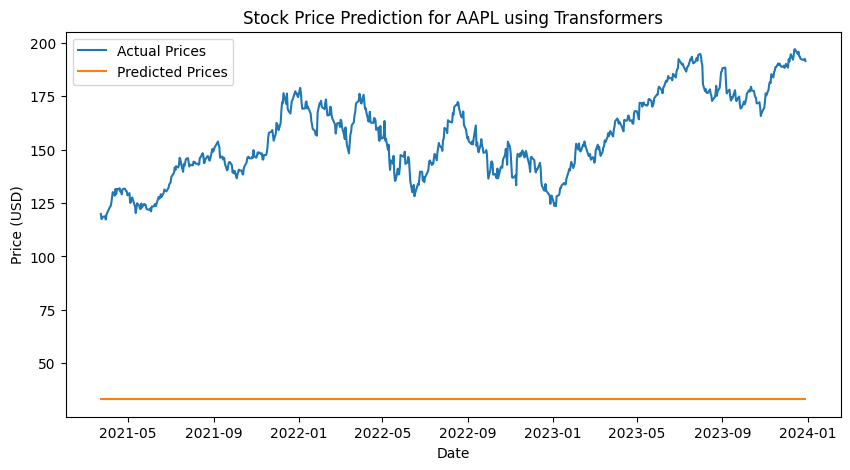

In [23]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test)

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(data.index[-len(y_test_rescaled):], y_test_rescaled, label="Actual Prices")
plt.plot(data.index[-len(y_test_rescaled):], y_pred_rescaled, label="Predicted Prices")
plt.legend()
plt.title(f"Stock Price Prediction for {stock_symbol} using Transformers")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()
